In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime

In [23]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train  = True,
    transform = transforms.ToTensor(),
    download = True
)

In [24]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [25]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [26]:
test_dataset.data.shape

torch.Size([10000, 28, 28])

In [27]:
K = len(set(train_dataset.targets.numpy()))
K

10

In [28]:
#define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels = 128, kernel_size = 3, stride =2),
            nn.ReLU()
        )
        self.dense_layers = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, K)
        )
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

In [29]:
#Instantiating the model
model = CNN(K)

In [30]:
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [31]:
#the same model using the newly introduced Flatten
#model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size = 3,stride=2),
#nn.ReLU(),
#                      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#                      nn.ReLU(),
#                      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#                      nn.ReLU(),
#                      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
#                      nn.ReLU(),
#                      nn.Flatten(),
#                      nn.Dropout(p=0.2),
#                      nn.Linear(128*2*2, 512),
#                      nn.Dropout(p=0.2),
#                      nn.Linear(512, K)
#                     )
                      
                      

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu


In [33]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
#Data loader
#Useful because it automatically  generates batches in the training loop
#and takes care of shuffling
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle = False)

In [35]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f8498d0fd90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8498d0f9d0>)

In [36]:
#A function to encapsulate the training loop
def batch_gd(model,criterion,optimizer,train_loader,test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            #move data to cpu
            inputs, targets = inputs.to(device), targets.to(device)
            #zero the parameter gradient
            optimizer.zero_grad()
            #Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            #Backward pass
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        #Get train and test loss
        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        #Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
    return train_losses, test_losses

In [37]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10, Train Loss: 0.6619, Test Loss: 0.4790, Duration: 0:00:28.705628
Epoch 2/10, Train Loss: 0.4388, Test Loss: 0.4070, Duration: 0:00:29.272182
Epoch 3/10, Train Loss: 0.3809, Test Loss: 0.3661, Duration: 0:00:23.648016
Epoch 4/10, Train Loss: 0.3478, Test Loss: 0.3411, Duration: 0:00:20.560871
Epoch 5/10, Train Loss: 0.3248, Test Loss: 0.3322, Duration: 0:00:26.774466
Epoch 6/10, Train Loss: 0.3003, Test Loss: 0.3220, Duration: 0:00:30.054686
Epoch 7/10, Train Loss: 0.2827, Test Loss: 0.3138, Duration: 0:00:29.991064
Epoch 8/10, Train Loss: 0.2655, Test Loss: 0.3009, Duration: 0:00:36.081571
Epoch 9/10, Train Loss: 0.2498, Test Loss: 0.2959, Duration: 0:00:29.206029
Epoch 10/10, Train Loss: 0.2378, Test Loss: 0.2854, Duration: 0:00:29.721889


<function matplotlib.pyplot.show(close=None, block=None)>

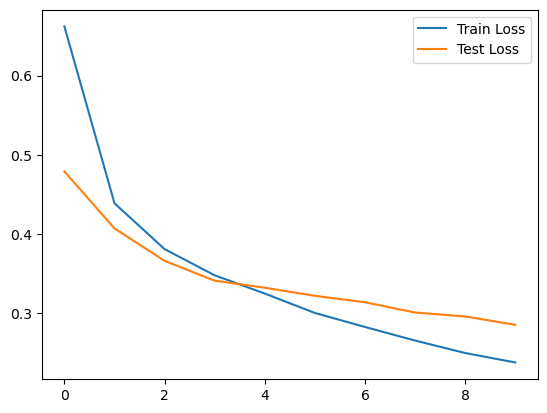

In [38]:
#plot the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show

In [39]:
#find accuracy
model.eval()
n_correct = 0
n_total = 0
for inputs , targets in train_loader:
    #move data to cpu
    inputs, targets = inputs.to(device), targets.to(device)
    #forward pass
    outputs = model(inputs)
    #get prediction
    _, predictions = torch.max(outputs, 1)
    
    #update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
train_acc = n_correct / n_total

n_correct = 0 
n_total = 0

for inputs, targets in test_loader:
    #move data to cpu 
    inputs, targets = inputs.to(device), targets.to(device)
    #forward pass
    outputs = model(inputs)
    #get predictions
    _, predictions = torch.max(outputs, 1)
    
    #update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]
test_acc = n_correct / n_total
print(f'Train Accuracy : {train_acc:.4f}, Test Accuracy : {test_acc:.4f}')

Train Accuracy : 0.9294, Test Accuracy : 0.8955


In [40]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix',cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalize confusion matrix')
    else:
        print('confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'if normalize else 'd'
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment='center',
                 color = 'white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()

confusion matrix, without normalization
[[871   0  17  21   6   1  79   0   5   0]
 [  1 976   0  15   3   0   3   0   2   0]
 [ 17   1 811  11  83   0  76   0   1   0]
 [ 14   7  22 900  38   0  19   0   0   0]
 [  0   1  29  20 869   0  80   0   1   0]
 [  0   0   0   2   0 970   0  18   0  10]
 [127   0  64  29 101   0 667   0  12   0]
 [  0   0   0   0   0  18   0 949   0  33]
 [  2   1   4   0   5   3   3   3 979   0]
 [  1   0   0   0   0   5   0  31   0 963]]


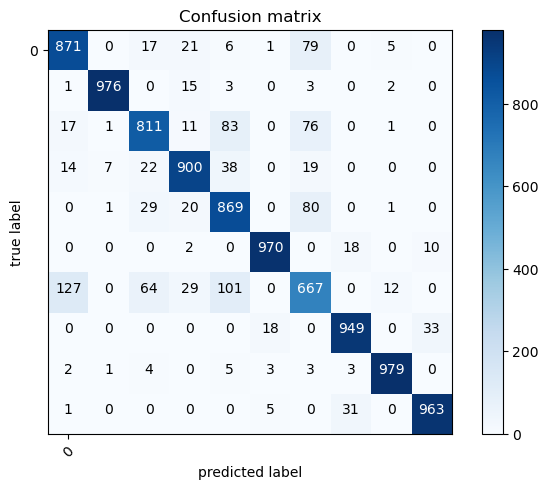

In [41]:
#get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    #move data to cpu
    inputs , targets = inputs.to(device), targets.to(device)
    #forward pass
    outputs = model(inputs)
    #get prediction
    _, predictions = torch.max(outputs, 1)

    #update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(1)))

In [42]:
#Label mapping
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

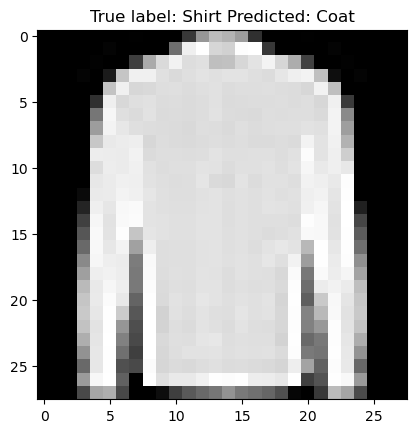

In [69]:
#Showing some misclassified examples
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap= 'gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

In [44]:
p_test

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [45]:
labels

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [46]:
x_test, y_test

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],